In [ ]:
import gdown
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pprint
import random
import pandas as pd
import pulp
import itertools
import requests
import random
from geopy.distance import geodesic
import time
import pandas as pd
import os

Downloading...
From (original): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf
From (redirected): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf&confirm=t&uuid=7b8aeac6-6a69-4d9a-99dc-89ee4a67f10e
To: /content/mpsis_setup.py
100%|██████████| 12.1k/12.1k [00:00<00:00, 21.8MB/s]


In [ ]:
def generate_random_point(sw_lat, sw_lng, ne_lat, ne_lng):
    lat = random.uniform(sw_lat, ne_lat)
    lng = random.uniform(sw_lng, ne_lng)
    return lat, lng

def snap_to_road(lat, lng, api_key):
    url = f'https://roads.googleapis.com/v1/nearestRoads?points={lat},{lng}&key={api_key}'
    response = requests.get(url)
    data = response.json()
    if 'snappedPoints' in data and len(data['snappedPoints']) > 0:
        snapped_point = data['snappedPoints'][0]['location']
        return snapped_point['latitude'], snapped_point['longitude']
    return None

def get_road_distance_time(origin, destination, api_key):
    origin_str = f'{origin[0]}, {origin[1]}'
    destination_str = f'{destination[0]}, {destination[1]}'
    departure_time = int(time.time()) + 24 * 3600
    url = (
        f'https://maps.googleapis.com/maps/api/distancematrix/json?units=metric&origins={origin_str}'
        f'&destinations={destination_str}&mode=driving&departure_time={departure_time}&key={api_key}'
    )
    response = requests.get(url)
    data = response.json()

    if data['status'] == 'OK':
        element = data['rows'][0]['elements'][0]
        if element['status'] == 'OK':
            distance_text = element['distance']['text']
            distance = float(distance_text.replace(' km', '').replace(',', ''))

            duration_text = element['duration']['text']
            duration_parts = duration_text.split()
            duration = int(duration_parts[0])
            if "hour" in duration_text:
                duration = int(duration_parts[0]) * 60 + int(duration_parts[2])

            return distance, duration
        else:
            return None, None
    else:
        return None, None

def find_center(sw_lat, sw_lng, ne_lat, ne_lng):
    center_lat = (sw_lat + ne_lat) / 2
    center_lng = (sw_lng + ne_lng) / 2
    return center_lat, center_lng

def generate_list(n, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")
    result = [0]
    random_values = np.random.rand(n - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    result.extend(rounded_values)

    return result

def crop_matrix(data, N):
    return [row[:N] for row in data[:N]]

import numpy as np

def generate_demand_list(n, m, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if m >= n:
        raise ValueError("M must be less than N.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")

    random_values = np.random.rand(n - m - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    zeros_list = [0] * m

    result = list(rounded_values) + zeros_list

    random.shuffle(result)

    result = [-1] + result

    return result
def replace_zeros_with_sum(input_list, target_sum):
    zero_positions = [i for i, value in enumerate(input_list) if value == 0]
    num_zeros = len(zero_positions)

    result = input_list.copy()

    if num_zeros == 0:
        raise ValueError("There are no zeros to replace in the list.")

    random_values = np.random.rand(num_zeros)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    for i, pos in enumerate(zero_positions):
        result[pos] = rounded_values[i]

    return result

def create_path_as_list(pairs_list):
    wanted_length = len(pairs_list)
    path = ''
    current_pair = next(pair for pair in pairs_list if pair[0] == 0)
    path += str(current_pair[0])

    next_start = current_pair[1]

    pairs_list.remove(current_pair)

    while len(path) < wanted_length:
        path += str(next_start)
        current_pair = next(pair for pair in pairs_list if pair[0] == next_start)
        pairs_list.remove(current_pair)
        next_start = current_pair[1]

    return path

def find_paths_vrb(edges, k):
    def find_path_vrb(current_path):
        if len(paths) >= k:
            return

        last_node = current_path[-1]

        if last_node == 0 and len(current_path) > 1:
            paths.append(current_path)
            return

        for edge in edges:
            if edge[0] == last_node:
                find_path_vrb(current_path + [edge[1]])

    paths = []
    find_path_vrb([0])

    return paths

def repetitions(list1, list2):
  common_elements = set(list1) & set(list2)
  return (2*len(common_elements))/len(list1+list2)

def equal_paths(list1, list2):
  are_equal = sorted(list1) == sorted(list2)
  if are_equal:
    return 1
  else:
    return 0

In [ ]:
df = pd.read_csv(os.path.join(output_dir, "X"))

In [ ]:
real_distance_columns = [col for col in df.columns if col.startswith('Road Distance to Point')]
df_filtered = df[real_distance_columns]

num_points = len(df_filtered)
cost = [[0] * num_points for _ in range(num_points)]

for i in range(num_points):
    for j in range(num_points):
        if i != j:
            column_name = f'Road Distance to Point {j + 1}'
            distance = df_filtered.iloc[i][column_name].replace(",", "").replace(" km", "")
            cost[i][j] = float(distance)

print("Cost matrix:")
for row in cost:
    print(f"{row},")

Cost matrix:
[0, 4.4, 4.0, 5.9, 10.8, 4.2, 3.0, 6.3, 2.8, 3.0, 2.3, 3.8, 1.6, 5.4, 4.2, 2.3, 3.0, 2.9, 3.0, 5.1, 1.5],
[4.4, 0, 6.1, 8.6, 9.6, 3.0, 3.9, 6.3, 2.8, 4.3, 3.4, 5.1, 2.0, 7.9, 4.2, 3.2, 4.0, 2.9, 3.0, 6.6, 3.0],
[4.0, 6.1, 0, 2.6, 14.1, 6.1, 1.4, 3.2, 4.9, 3.9, 2.5, 6.7, 3.0, 1.8, 5.0, 1.7, 2.8, 3.6, 2.7, 6.0, 2.9],
[5.9, 8.6, 2.6, 0, 16.0, 8.0, 3.1, 2.0, 6.8, 5.5, 4.1, 8.3, 4.7, 0.4, 6.9, 3.4, 4.4, 5.6, 4.6, 7.6, 4.6],
[10.8, 9.6, 14.1, 16.0, 0, 8.2, 11.5, 13.0, 10.4, 12.2, 11.0, 11.2, 9.6, 14.5, 10.9, 10.8, 11.7, 9.6, 10.7, 13.7, 10.6],
[4.2, 3.0, 6.1, 8.0, 8.2, 0, 7.3, 6.1, 4.7, 7.8, 5.5, 6.8, 4.2, 7.6, 4.0, 5.3, 6.2, 2.7, 3.8, 9.3, 5.2],
[3.0, 3.9, 1.4, 3.1, 11.5, 7.3, 0, 4.6, 5.1, 3.7, 2.3, 6.5, 2.9, 3.0, 7.2, 2.1, 1.9, 5.8, 4.9, 5.4, 2.7],
[6.3, 6.3, 3.2, 2.0, 13.0, 6.1, 4.6, 0, 4.8, 7.0, 5.6, 9.4, 6.3, 1.6, 5.0, 4.8, 5.9, 3.6, 2.7, 9.1, 6.0],
[2.8, 2.8, 4.9, 6.8, 10.4, 4.7, 5.1, 4.8, 0, 5.1, 4.2, 5.9, 2.8, 6.4, 3.6, 4.0, 4.8, 2.3, 2.1, 7.4, 3.8],
[3.0, 4.3, 3.9, 5.5,

VRPB

In [ ]:
number_of_clients = 20

L_B = list(range(1, number_of_clients + 1))
SOURCE = 0
midpoint = number_of_clients - 4
L = L_B[:midpoint]
L0 = L[:]
L0.insert(0,0)
B = L_B[midpoint:]
B0 = B[:]
B0.insert(0,0)
Cu = L_B
V = list(range(0, number_of_clients + 1))
print(B)

Q = 100
K = 2

D = generate_list(len(L) + 1, 2 * Q * K)
D.append(1)
D.append(1)
D.append(1)
D.append(1)

print(sum(D))

Kl = K
Kb = K

[17, 18, 19, 20]
403.99999999999994


In [ ]:
from posixpath import join

s = pulp.LpVariable.dicts('s', [(i, j) for i in V for j in V if i != j], cat = pulp.LpBinary)
e = pulp.LpVariable.dicts('e', [(i, j) for i in L for j in B0 if i != j], cat = pulp.LpBinary)
l = pulp.LpVariable.dicts('l', [(i, j) for i in V for j in V if i != j], 0, cat = "Continuous")

model = pulp.LpProblem("vehicle_routing", pulp.LpMinimize)

cost_function = pulp.lpSum(s[i,j] * cost[i][j] for i in V for j in V if i != j) + pulp.lpSum(e[i,j] * cost[i][j] for i in L for j in B0 if i != j)
model += cost_function

model += pulp.lpSum(s[i,j] for i in L0 for j in L if i != j) == len(L)

for j in L:
  model += pulp.lpSum(l[i,j] for i in L0 if i != j) - pulp.lpSum(l[j,k] for k in L0 if k != j) == D[j]

for j in L:
  model += pulp.lpSum(s[i,j] for i in L0 if i != j) == 1

for j in L:
  model += pulp.lpSum(s[j,k] for k in L if k != j) + pulp.lpSum(e[j,k] for k in B0 if k != j)  ==  pulp.lpSum(s[(i,j)] for i in L0 if i != j)

for j in L:
  for i in L0:
    if i != j:
      model += l[(i,j)] <= Q * s[(i,j)]

fraaction7 = pulp.lpSum(D[j] for j in L)/Q
model += pulp.lpSum(s[0,j] for j in L) >= max(float(fraaction7.value()),Kl)

model += pulp.lpSum(s[i,j] for i in B for j in B0 if i != j) == len(B)

for j in B:
  model += pulp.lpSum(l[i,j] for i in B if i != j) - pulp.lpSum(l[(j,k)] for k in B0 if k != j) == -D[j]

for j in B:
  model += pulp.lpSum(s[j,i] for i in B0 if j != i) == 1

for j in B:
  model += pulp.lpSum(s[k,j] for k in B if k != j) + pulp.lpSum(e[k,j] for k in L) == pulp.lpSum(s[(j,i)] for i in B0 if j != i)

for j in B0:
  for i in B:
    if i != j:
      model += l[i,j] <= Q * s[i,j]

fraaction13 = pulp.lpSum(D[j] for j in B)/Q
model += max(int(fraaction13.value()),Kb) <= pulp.lpSum(s[i,0] for i in B)
model += pulp.lpSum(s[(i,0)] for i in B) <= pulp.lpSum(s[0, j] for j in L)

model += pulp.lpSum(s[i,0] for i in B) + pulp.lpSum(e[i, 0] for i in L) == pulp.lpSum(s[0,j] for j in L)

for i in V:
  for j in V:
    if i != j:
      model += s[i,j] + s[j,i] <= 1



model += pulp.lpSum(s[i,j] for i in B for j in L if i != j) == 0

model += pulp.lpSum(s[0, j] for j in B) == 0

model += pulp.lpSum(s[i,j] for i in L for j in B0 if i != j) == 0

In [ ]:
model.solve()
print("Total Cost:", pulp.value(model.objective))

Total Cost: 75.85


In [ ]:
if m == 2:
  nof_stops = [0,0]
  cost_function_for_vechicle = [0,0]
else:
  nof_stops = [0,0,0,0]
  cost_function_for_vechicle = [0,0,0,0]

strings_nof_stops = []
strings_cost_function_for_vechicle = []

for klucz in [(i, j, k) for i in range(n+1) for j in range(n+1) for k in range(m)]:
  if  x[klucz].varValue == 1:
    print(f'klucz {klucz} wartosc: {x[klucz].varValue}')
    nof_stops[klucz[2]] += 1
    cost_function_for_vechicle[klucz[2]] += cost[klucz[0]][klucz[1]]


for i in V:
  for j in V:
    if i != j:
      if  s[i,j].varValue == 1:
        print(f'klucz {i,j} wartosc{s[i,j].varValue}')
print("#############################")
for i in L:
   for j in B0:
     if i != j:
      if  e[i,j].varValue == 1:
        print(f'klucz {i,j} wartosc{e[i,j].varValue}')

klucz (0, 6) wartosc1.0
klucz (0, 8) wartosc1.0
klucz (0, 10) wartosc1.0
klucz (0, 11) wartosc1.0
klucz (0, 15) wartosc1.0
klucz (1, 12) wartosc1.0
klucz (2, 16) wartosc1.0
klucz (3, 13) wartosc1.0
klucz (4, 5) wartosc1.0
klucz (5, 1) wartosc1.0
klucz (6, 2) wartosc1.0
klucz (8, 14) wartosc1.0
klucz (11, 4) wartosc1.0
klucz (13, 7) wartosc1.0
klucz (15, 3) wartosc1.0
klucz (16, 9) wartosc1.0
klucz (17, 0) wartosc1.0
klucz (18, 0) wartosc1.0
klucz (19, 0) wartosc1.0
klucz (20, 0) wartosc1.0
#############################
klucz (7, 18) wartosc1.0
klucz (9, 19) wartosc1.0
klucz (10, 20) wartosc1.0
klucz (12, 0) wartosc1.0
klucz (14, 17) wartosc1.0


Check percentege of load


In [ ]:
nof_runs = 2
data_generation_percentege =[0.0, 0.1,  0.2, 0.3,  0.4,  0.5,  0.6,  0.7, 0.8, 0.9]
output = []

In [ ]:
import time

TIME = []

for percent in data_generation_percentege:
    output.append([])
    start_time = time.time()
    for run_number in range(nof_runs):
      n = 10
      m = 2
      Q = 100

      d = generate_list(n + 1, percent * Q * m)
      p = generate_list(n + 1, percent * Q * m)

      vrpsdp = pulp.LpProblem("VRPSDP", pulp.LpMinimize)

      x = pulp.LpVariable.dicts("x", [(i, j, k) for i in range(n+1) for j in range(n+1) for k in range(m)], cat='Binary')
      y = pulp.LpVariable.dicts("y", [(i, j) for i in range(n+1) for j in range(n+1)], lowBound=0, cat='Continuous')
      z = pulp.LpVariable.dicts("z", [(i, j) for i in range(n+1) for j in range(n+1)], lowBound=0, cat='Continuous')

      vrpsdp += pulp.lpSum(cost[i][j] * x[i, j, k] for k in range(m) for i in range(n+1) for j in range(n+1) if i != j)

      for j in range(1, n+1):
          vrpsdp += pulp.lpSum(x[i, j, k] for k in range(m) for i in range(n+1) if i != j) == 1

      for k in range(m):
        for j in range(n+1):
          vrpsdp += pulp.lpSum(x[i,j,k] for i in range(n+1)) - pulp.lpSum(x[j,i,k] for i in range(n+1)) == 0

      for k in range(m):
        vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1)) == 1

      for j in range(1, n+1):
        vrpsdp += pulp.lpSum(y[j,i] for i in range(n+1)) - pulp.lpSum(y[i,j] for i in range(n+1)) == p[j]

      for j in range(1, n+1):
        vrpsdp += pulp.lpSum(z[i,j] for i in range(n+1)) - pulp.lpSum(z[j,i] for i in range(n+1)) == d[j]

      for i in range(n+1):
        for j in range(n+1):
          if i != j:
            vrpsdp += y[i,j] + z[i,j] <= Q * pulp.lpSum(x[i,j,k] for k in range(m))

      vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1) for k in range(m)) == m
      vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1) for k in range(m)) == m
      for i in range(1,n+1):
        vrpsdp += pulp.lpSum(x[i,j,k] for j in range(n+1) for k in range(m) if i != j) == 1
        vrpsdp += pulp.lpSum(x[j,i,k] for j in range(n+1) for k in range(m) if i != j) == 1

      vrpsdp.solve()

      if pulp.LpStatus[vrpsdp.status] == "Optimal":
        print(f"Total Cost for {percent}% and run {run_number}:, {pulp.value(vrpsdp.objective)/100}")

      output[data_generation_percentege.index(percent)].append(pulp.value(vrpsdp.objective)/100)

    print(output[-1])

    end_time = time.time()
    elapsed_time = end_time - start_time

    TIME.append(elapsed_time)

    print(f"Elapsed time: {elapsed_time} seconds")

Total Cost for 0.0% and run 0:, 0.3939999999999999
Total Cost for 0.0% and run 1:, 0.3939999999999999
[0.3939999999999999, 0.3939999999999999]
Elapsed time: 0.1872847080230713 seconds
Total Cost for 0.1% and run 0:, 0.46099999999999985
Total Cost for 0.1% and run 1:, 0.46099999999999985
[0.46099999999999985, 0.46099999999999985]
Elapsed time: 3.9640488624572754 seconds
Total Cost for 0.2% and run 0:, 0.46099999999999985
Total Cost for 0.2% and run 1:, 0.46099999999999997
[0.46099999999999985, 0.46099999999999997]
Elapsed time: 11.33200454711914 seconds
Total Cost for 0.3% and run 0:, 0.46099999999999985
Total Cost for 0.3% and run 1:, 0.46099999999999997
[0.46099999999999985, 0.46099999999999997]
Elapsed time: 5.65700626373291 seconds
Total Cost for 0.4% and run 0:, 0.46099999999999985
Total Cost for 0.4% and run 1:, 0.46099999999999997
[0.46099999999999985, 0.46099999999999997]
Elapsed time: 6.8765668869018555 seconds
Total Cost for 0.5% and run 0:, 0.46099999999999985
Total Cost for 

In [ ]:
TIME_executiom = [x * 10 for x in TIME]

In [ ]:
TIME_executiom

[1.872847080230713,
 39.640488624572754,
 56.5700626373291,
 68.76566886901855,
 78.40340375900269,
 80.45135736465454,
 106.72823190689087,
 113.3200454711914,
 128.28680276870728,
 681.0059571266174]

In [ ]:
os.makedirs(output_dir, exist_ok=True)
file_path = os.path.join(output_dir, "X")
import csv
with open(file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    for item in output:
        writer.writerow([item])

In [ ]:
output = []
for percent in data_generation_percentege:
    output.append([])
    for run_number in range(nof_runs):
      n = 10
      m = 3
      Q = 100

      d = generate_list(n + 1, percent * Q * m)
      p = generate_list(n + 1, percent * Q * m)

      vrpsdp = pulp.LpProblem("VRPSDP", pulp.LpMinimize)

      x = pulp.LpVariable.dicts("x", [(i, j, k) for i in range(n+1) for j in range(n+1) for k in range(m)], cat='Binary')
      y = pulp.LpVariable.dicts("y", [(i, j) for i in range(n+1) for j in range(n+1)], lowBound=0, cat='Continuous')
      z = pulp.LpVariable.dicts("z", [(i, j) for i in range(n+1) for j in range(n+1)], lowBound=0, cat='Continuous')

      vrpsdp += pulp.lpSum(cost[i][j] * x[i, j, k] for k in range(m) for i in range(n+1) for j in range(n+1) if i != j)

      for j in range(1, n+1):
          vrpsdp += pulp.lpSum(x[i, j, k] for k in range(m) for i in range(n+1) if i != j) == 1

      for k in range(m):
        for j in range(n+1):
          vrpsdp += pulp.lpSum(x[i,j,k] for i in range(n+1)) - pulp.lpSum(x[j,i,k] for i in range(n+1)) == 0

      for k in range(m):
        vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1)) == 1

      for j in range(1, n+1):
        vrpsdp += pulp.lpSum(y[j,i] for i in range(n+1)) - pulp.lpSum(y[i,j] for i in range(n+1)) == p[j]

      for j in range(1, n+1):
        vrpsdp += pulp.lpSum(z[i,j] for i in range(n+1)) - pulp.lpSum(z[j,i] for i in range(n+1)) == d[j]

      for i in range(n+1):
        for j in range(n+1):
          if i != j:
            vrpsdp += y[i,j] + z[i,j] <= Q * pulp.lpSum(x[i,j,k] for k in range(m))

      vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1) for k in range(m)) == m
      vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1) for k in range(m)) == m
      for i in range(1,n+1):
        vrpsdp += pulp.lpSum(x[i,j,k] for j in range(n+1) for k in range(m) if i != j) == 1
        vrpsdp += pulp.lpSum(x[j,i,k] for j in range(n+1) for k in range(m) if i != j) == 1

      vrpsdp.solve()

      if pulp.LpStatus[vrpsdp.status] == "Optimal":
        print(f"Total Cost for {percent}% and run {run_number}:, {pulp.value(vrpsdp.objective)/100}")

      output[data_generation_percentege.index(percent)].append(pulp.value(vrpsdp.objective)/100)

    print(output[-1])

Total Cost for 0.0% and run 0:, 25.6
Total Cost for 0.0% and run 1:, 25.6
Total Cost for 0.0% and run 2:, 25.6
Total Cost for 0.0% and run 3:, 25.6
Total Cost for 0.0% and run 4:, 25.6
Total Cost for 0.0% and run 5:, 25.6
Total Cost for 0.0% and run 6:, 25.6
Total Cost for 0.0% and run 7:, 25.6
Total Cost for 0.0% and run 8:, 25.6
Total Cost for 0.0% and run 9:, 25.6
Total Cost for 0.0% and run 10:, 25.6
Total Cost for 0.0% and run 11:, 25.6
Total Cost for 0.0% and run 12:, 25.6
Total Cost for 0.0% and run 13:, 25.6
Total Cost for 0.0% and run 14:, 25.6
Total Cost for 0.0% and run 15:, 25.6
Total Cost for 0.0% and run 16:, 25.6
Total Cost for 0.0% and run 17:, 25.6
Total Cost for 0.0% and run 18:, 25.6
Total Cost for 0.0% and run 19:, 25.6
[25.6, 25.6, 25.6, 25.6, 25.6, 25.6, 25.6, 25.6, 25.6, 25.6, 25.6, 25.6, 25.6, 25.6, 25.6, 25.6, 25.6, 25.6, 25.6, 25.6]
Total Cost for 0.05% and run 0:, 28.3
Total Cost for 0.05% and run 1:, 28.3
Total Cost for 0.05% and run 2:, 28.3
Total Cost for 

KeyboardInterrupt: 

In [ ]:
output = []
for percent in data_generation_percentege:
    output.append([])
    for run_number in range(nof_runs):
      n = 10
      m = 4
      Q = 100


      d = generate_list(n + 1, percent * Q * m)
      p = generate_list(n + 1, percent * Q * m)

      vrpsdp = pulp.LpProblem("VRPSDP", pulp.LpMinimize)

      x = pulp.LpVariable.dicts("x", [(i, j, k) for i in range(n+1) for j in range(n+1) for k in range(m)], cat='Binary')
      y = pulp.LpVariable.dicts("y", [(i, j) for i in range(n+1) for j in range(n+1)], lowBound=0, cat='Continuous')
      z = pulp.LpVariable.dicts("z", [(i, j) for i in range(n+1) for j in range(n+1)], lowBound=0, cat='Continuous')

      vrpsdp += pulp.lpSum(cost[i][j] * x[i, j, k] for k in range(m) for i in range(n+1) for j in range(n+1) if i != j)

      for j in range(1, n+1):
          vrpsdp += pulp.lpSum(x[i, j, k] for k in range(m) for i in range(n+1) if i != j) == 1

      for k in range(m):
        for j in range(n+1):
          vrpsdp += pulp.lpSum(x[i,j,k] for i in range(n+1)) - pulp.lpSum(x[j,i,k] for i in range(n+1)) == 0

      for k in range(m):
        vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1)) == 1

      for j in range(1, n+1):
        vrpsdp += pulp.lpSum(y[j,i] for i in range(n+1)) - pulp.lpSum(y[i,j] for i in range(n+1)) == p[j]

      for j in range(1, n+1):
        vrpsdp += pulp.lpSum(z[i,j] for i in range(n+1)) - pulp.lpSum(z[j,i] for i in range(n+1)) == d[j]

      for i in range(n+1):
        for j in range(n+1):
          if i != j:
            vrpsdp += y[i,j] + z[i,j] <= Q * pulp.lpSum(x[i,j,k] for k in range(m))

      vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1) for k in range(m)) == m
      for i in range(1,n+1):
        vrpsdp += pulp.lpSum(x[i,j,k] for j in range(n+1) for k in range(m) if i != j) == 1

      vrpsdp.solve()

      if pulp.LpStatus[vrpsdp.status] == "Optimal":
        print(f"Total Cost for {percent}% and run {run_number}:, {pulp.value(vrpsdp.objective)/100}")

      output[data_generation_percentege.index(percent)].append(pulp.value(vrpsdp.objective)/100)

    print(output[-1])

Total Cost for 0.0% and run 0:, 29.8
Total Cost for 0.0% and run 1:, 29.8
Total Cost for 0.0% and run 2:, 29.8
Total Cost for 0.0% and run 3:, 29.8
Total Cost for 0.0% and run 4:, 29.8
Total Cost for 0.0% and run 5:, 29.8
Total Cost for 0.0% and run 6:, 29.8
Total Cost for 0.0% and run 7:, 29.8
Total Cost for 0.0% and run 8:, 29.8
Total Cost for 0.0% and run 9:, 29.8
Total Cost for 0.0% and run 10:, 29.8
Total Cost for 0.0% and run 11:, 29.8
Total Cost for 0.0% and run 12:, 29.8
Total Cost for 0.0% and run 13:, 29.8
Total Cost for 0.0% and run 14:, 29.8
Total Cost for 0.0% and run 15:, 29.8
Total Cost for 0.0% and run 16:, 29.8
Total Cost for 0.0% and run 17:, 29.8
Total Cost for 0.0% and run 18:, 29.8
Total Cost for 0.0% and run 19:, 29.8
[29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8, 29.8]
Total Cost for 0.05% and run 0:, 33.2
Total Cost for 0.05% and run 1:, 33.2000000000054
Total Cost for 0.05% and run 2:, 33.2
Tot

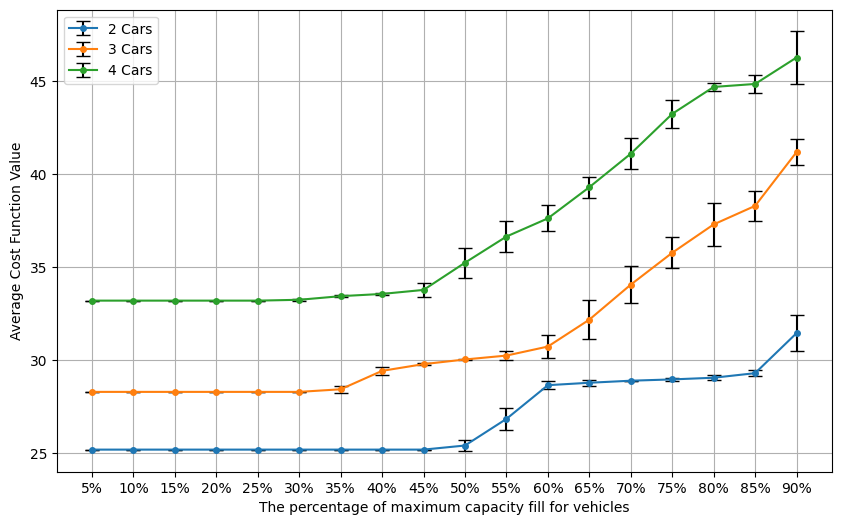

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

data_2_cars = np.array([
    [25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.199999999999992, 25.2, 25.200000000000045, 25.2, 25.199999999994674, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.20000000000047, 25.2],
    [25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.200000000001104, 25.2, 25.2, 25.2, 25.20000000000001, 25.2],
    [25.200000000000284, 25.20000000000001, 25.2, 25.2, 25.2, 25.2, 25.199999999999996, 25.2, 25.200000000000287, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2],
    [25.199999999999992, 25.199999756860716, 25.200000000001396, 25.199999999999996, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.200000000000095, 25.2, 25.2, 25.2, 25.200000000000028, 25.2, 25.2, 25.2, 25.2, 25.199999999999953],
    [25.2, 25.2, 25.2, 25.2, 25.200000000000056, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.200000000000067, 25.199999999999992, 25.2],
    [25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2],
    [25.2, 25.2, 25.2, 25.2, 25.2, 25.200000000000017, 25.2, 25.2, 25.200000000000045, 25.2, 25.199999999999157, 25.2, 25.2, 25.19999983760863, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2],
    [25.199999999999996, 25.199999999999978, 25.2, 25.20000000000001, 25.2, 25.2, 25.199999520000027, 25.200000000000028, 25.2, 25.2, 25.199999987869028, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.2],
    [25.2, 25.2, 25.2, 25.2, 25.2, 25.2, 25.199999999999996, 25.2, 25.2, 25.2, 25.20000000000001, 25.2, 25.2, 25.2, 25.200000000000017, 25.2, 25.2, 25.200000000000003, 25.2, 25.2],
    [25.2, 25.2, 27.500000000000036, 26.6, 25.199999939625787, 25.2, 25.2, 25.2, 25.199999992306335, 25.2, 25.9, 25.2, 25.2, 25.2, 25.2, 25.2, 25.200000000000003, 25.20000000000003, 25.2, 25.200000000003083],
    [25.2, 27.799999999999955, 28.9, 27.8, 25.2, 28.9, 25.20000000000152, 26.60000000000007, 26.6, 25.2, 27.8, 27.799999999999986, 25.2, 26.6, 26.100000000000005, 27.799999999999976, 25.2, 27.8, 27.5, 27.800000000000004],
    [28.7, 28.900000000000006, 28.9, 27.8, 28.9, 28.9, 28.7, 28.899999999999977, 28.9, 28.9, 28.90000000000001, 27.8, 28.9, 28.9, 27.8, 28.899999660000002, 28.9, 28.9, 28.9, 27.8],
    [28.9, 28.9, 28.9, 28.900000000000006, 28.9, 28.9, 28.9, 28.9, 28.89999833618461, 27.8, 28.9, 28.9, 28.899999999999768, 28.9, 28.9, 28.900000000000013, 27.8, 28.90000000000001, 28.9, 28.9],
    [28.9, 28.90000000000006, 28.9, 28.9, 28.9, 28.9, 28.9, 28.9, 28.900000000000134, 28.900000000000446, 28.9, 28.900000000000013, 28.900000000000073, 28.9, 28.9, 28.9, 28.9, 28.9, 28.9, 28.9],
    [28.9, 28.9, 28.9, 28.9, 28.9, 28.9, 29.6, 28.90000000000001, 28.900000000000063, 28.9, 28.9, 28.9, 29.200000000000042, 28.900000000000063, 28.900000000000006, 28.9, 28.900000000000063, 29.3, 28.9, 28.9],
    [28.9, 28.90000000000002, 28.9, 28.90000000000003, 28.9, 29.8, 28.9, 29.400000000000336, 28.9, 29.3, 28.9, 29.5, 28.9, 28.9, 29.7, 28.9, 28.9, 28.9, 28.899999999999988, 28.9],
    [28.9, 29.699999999999974, 28.9, 29.5, 29.3, 28.9, 30.2, 28.9, 29.6, 28.9, 29.49999999999999, 29.3, 28.900000000000055, 29.5, 29.3, 29.700000000000014, 29.6, 28.9, 29.3, 29.3],
    [32.00000000000001, 33.3, 29.6, 29.6, 33.3, 33.7, 29.7, 32.49, 34.1, 29.8, 29.3, 29.7, 31.1, 34.70000000000005, 33.3, 29.8, 29.3, 29.79999999999997, 29.8, 34.69]
])

data_3_cars = np.array([
    [28.3, 28.3, 28.3, 28.3, 28.300000000000782, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3],
    [28.3, 28.3, 28.29999999999992, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.30000000000057],
    [28.29999999999997, 28.3, 28.3, 28.3, 28.3, 28.3, 28.300000000000004, 28.3, 28.3, 28.3, 28.3, 28.3, 28.300000000000185, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3],
    [28.299999999999905, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.299999999999873, 28.3, 28.3],
    [28.3, 28.3, 28.3, 28.30000000000472, 28.29999850571379, 28.30000000001482, 28.3, 28.3000000000001, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.3, 28.299999937508073, 28.3, 28.299999999999812],
    [28.3, 28.3, 28.300000000002136, 28.3, 28.3, 28.3, 28.30000000000018, 28.3, 28.3, 28.3, 28.3, 28.29999981175795, 28.3, 28.3, 28.3, 28.3, 28.299999999999997, 28.3, 28.3, 28.3],
    [28.3, 28.3, 28.300000000000015, 28.3, 28.300000000000356, 28.3, 28.3, 28.3, 28.3, 28.3, 29.70000000000001, 28.3, 29.69999998355946, 28.3, 28.3, 28.30000000000009, 28.3, 28.29999994, 28.3, 28.299999999999976],
    [29.2, 29.2, 30.0, 29.7, 29.7, 29.7, 29.7, 28.3, 29.2, 30.000000000000053, 29.70000000000311, 29.0, 29.7, 29.7, 29.2, 29.7, 29.7, 29.7, 29.2, 28.3],
    [29.700000000000227, 29.99999999999995, 29.69999999999883, 29.7, 30.0, 29.7, 30.0, 29.7, 30.0, 29.7, 29.7, 29.7, 29.699999999999918, 29.7, 29.699999999999992, 30.0, 29.7, 29.7, 30.0, 29.7],
    [30.0, 29.99999984288568, 30.1, 30.0, 30.2, 29.7, 30.100000000002982, 30.0, 30.2, 30.1, 30.1, 30.0, 30.0, 30.1, 30.0, 30.0, 29.999999934536117, 30.0, 30.1, 30.09999999999981],
    [30.2, 30.0, 30.2, 30.3, 30.1, 30.3, 30.1, 30.1, 30.1, 30.1, 30.2, 29.69999999999992, 30.1, 32.49, 30.1, 30.199999999999754, 30.2, 30.2, 30.199999999999783, 30.1],
    [30.2, 31.69, 30.1, 30.1, 30.1, 34.9, 30.1, 32.9, 30.1, 30.2, 30.1, 30.1, 30.1, 30.1, 30.199999999999623, 30.299999999999997, 30.2, 30.2, 30.1, 32.89],
    [33.0, 33.2, 33.0, 35.58999999999994, 35.70000000000002, 33.2, 30.60000000000001, 30.3, 35.3, 30.3, 30.3, 35.8, 30.4, 34.50000000000001, 31.4, 30.3, 30.3, 30.2, 30.100000000000083, 30.099999999999955],
    [33.2, 34.1, 35.2, 35.90000000000016, 36.89, 35.900000000000205, 33.0, 36.299999998987886, 36.59, 33.199999999999825, 34.9, 32.4, 30.2, 30.3, 35.9, 30.3, 34.1, 33.0, 34.9, 34.9],
    [34.9, 37.29, 33.2, 36.199999999999925, 33.20000000000001, 33.2, 37.89000000000047, 36.48999999999999, 34.900000000000006, 35.89, 36.08999999999998, 33.2, 37.49, 35.89, 37.28999999999949, 37.39, 37.29000000000021, 38.19, 33.2, 36.2],
    [37.38999999999999, 34.9, 40.68, 34.9, 34.9, 37.590000000000046, 37.389999999999965, 38.089999999999975, 38.09, 37.28999999999999, 35.4, 38.39, 34.89999999999914, 41.280000000000015, 33.2, 34.9, 37.29000000000022, 41.3799999999993, 35.88999999999996, 42.000000000002785],
    [37.88999999999996, 33.2, 39.28000000000001, 40.78, 38.4, 37.59, 41.49, 38.19, 39.00000000000002, 39.7, 37.290000000000006, 37.69999999999372, 37.89, 38.09, 37.7, 40.09999999999975, 38.69, 37.7, 36.89, 38.19],
    [41.57999999999938, 40.78, 41.88, 40.49, 39.0, 39.69, 43.280000000000015, 42.58, 40.58000000000002, 40.58, 44.29, 38.29, 41.89, 42.15, 40.98, 41.67, 39.45, 42.79, 40.36, 41.23]
])

data_4_cars = np.array([
  [33.2, 33.2000000000054, 33.2, 33.2, 33.200000000000635, 33.2, 33.2, 33.2, 33.200000000006895, 33.2, 33.2, 33.2, 33.19999999999934, 33.20000000003401, 33.20000000000803, 33.20000000000071, 33.19999999999997, 33.200000000000635, 33.2, 33.20000000000254],
  [33.2, 33.2, 33.2, 33.20000000000291, 33.2, 33.20000000000134, 33.20000000000007, 33.2, 33.199999999999726, 33.19999999999605, 33.19999999999923, 33.2, 33.20000000000087, 33.2, 33.2, 33.2, 33.200000000000045, 33.2, 33.2, 33.20000000000206],
  [33.2, 33.2, 33.2, 33.2, 33.2, 33.200000000001616, 33.2, 33.20000000001583, 33.20000000000077, 33.2, 33.2, 33.2, 33.2, 33.20000000000057, 33.2, 33.2, 33.19999999999581, 33.2, 33.2, 33.2],
  [33.2, 33.2, 33.2, 33.2, 33.20000000000257, 33.19999999999968, 33.2, 33.2, 33.2, 33.2, 33.20000000000002, 33.19999999999982, 33.2, 33.2, 33.199999999999996, 33.2, 33.2, 33.20000000000197, 33.2, 33.2],
  [33.2, 33.2, 33.2, 33.2, 33.2, 33.2, 33.2, 33.20000000000072, 33.199995123076, 33.2, 33.2, 33.2, 33.2, 33.2, 33.20000000000025, 33.2, 33.2, 33.2, 33.2, 33.2],
  [33.2, 33.499999999894975, 33.19999999999971, 33.2, 33.199999840000004, 33.2, 33.2, 33.2, 33.2, 33.2, 33.20000000000001, 33.50000000000037, 33.2, 33.5, 33.2, 33.2, 33.2, 33.2, 33.2, 33.200000000005176],
  [33.2, 33.2, 33.5, 33.5, 33.5, 33.5, 33.2, 33.5, 33.50000000000001, 33.5, 33.5, 33.49999990558783, 33.5, 33.2, 33.5, 33.5, 33.5, 33.5, 33.5, 33.5],
  [33.5, 33.5, 33.5, 33.7, 33.49999999999994, 33.5, 33.5, 33.7, 33.5, 33.5, 33.5, 33.5, 33.7, 33.69999999999962, 33.49999938896053, 33.5, 33.5, 33.5, 33.7, 33.7],
  [33.5, 33.69999999999927, 33.7, 33.5, 33.7, 33.5, 33.7, 33.5, 33.5, 33.7, 33.5, 33.7, 33.5, 37.0, 33.499999999997534, 33.70000000000004, 33.7, 33.69999996143485, 33.5, 33.7],
  [33.7, 38.29, 33.7, 33.5, 33.7, 36.38999999999994, 37.1, 33.5, 33.7, 36.39, 33.7, 36.39, 33.49999999999999, 36.39, 33.7, 37.00000000000001, 37.1, 36.39000000000004, 37.1, 33.5],
  [38.69, 38.59, 34.2, 35.4, 35.4, 37.79000000000021, 35.4, 38.59, 37.100000000000534, 38.59000000000005, 35.4, 33.7, 37.4, 35.40000000000034, 38.1, 36.99, 38.4, 35.4, 33.7, 38.59],
  [38.69, 38.59, 38.59, 34.9, 38.69, 35.4, 35.20000000000021, 38.69, 35.4, 38.68999999999707, 38.69, 35.4, 38.69, 38.59, 38.69, 38.79, 38.69, 37.389999999999965, 37.39, 37.19000000000012],
  [38.89, 38.69000000000001, 40.79, 38.69, 39.19, 39.199999999384254, 40.09, 39.99, 39.2, 38.69, 38.79, 39.19, 38.69, 37.0, 41.2, 38.69, 38.69, 38.69, 38.69, 42.77],
  [40.20000000000002, 41.29, 39.990000000004386, 41.98, 42.49, 45.09, 40.2, 41.19, 40.79, 43.489999999997366, 41.49, 44.08, 40.2, 38.89, 38.69, 38.690000000000516, 41.58, 41.49, 38.99, 40.99000000000007],
  [44.68000000000002, 43.49, 40.2, 44.4, 44.47999999999999, 43.58999999991755, 43.58, 42.09, 43.59, 42.09000000000009, 41.49, 44.88, 39.39, 41.89, 44.87999999999846, 44.38, 43.7, 44.9, 43.28, 43.58],
    [
    43.7, 44.78, 43.87, 44.98, 45.19, 43.68, 44.58, 45.19,
    44.49, 44.29, 44.59, 44.99, 44.9, 44.98, 44.98, 44.48,
    44.98, 44.98, 44.88, 44.98
],
  [
    43.6, 44.98, 43.87, 45.98, 44.99, 43.48, 44.58, 46.99,
    42.49, 44.19, 44.59, 46.89, 44.9, 44.98, 44.98, 44.38,
    44.98, 44.98, 45.88, 44.98
],
  [42.1, 54.78, 47.87, 47.27999999999991, 43.59, 46.68, 50.58000000000002, 44.689999999952136, 48.99, 42.69, 46.59, 43.39, 47.89999999999919, 44.48, 45.98, 42.88, 44.98, 45.98, 44.68, 48.979999999999016],
])


def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data, axis=1)
    std_dev = np.std(data, axis=1, ddof=1)
    n = data.shape[1]
    df = n - 1
    t_value = stats.t.ppf(1 - (1 - confidence) / 2, df)
    ci = t_value * std_dev / np.sqrt(n)
    return mean_val, ci

mean_2_cars, ci_2_cars = confidence_interval(data_2_cars)
mean_3_cars, ci_3_cars = confidence_interval(data_3_cars)
mean_4_cars, ci_4_cars = confidence_interval(data_4_cars)

load_percentages = np.arange(5, 95, 5)

plt.figure(figsize=(10, 6))

plt.errorbar([f"{num}%" for num in load_percentages], mean_2_cars, yerr=ci_2_cars, label='2 Cars', fmt='-o', markersize=4, capsize=5, ecolor='black')
plt.errorbar([f"{num}%" for num in load_percentages], mean_3_cars, yerr=ci_3_cars, label='3 Cars', fmt='-o', markersize=4, capsize=5, ecolor='black')
plt.errorbar([f"{num}%" for num in load_percentages], mean_4_cars, yerr=ci_4_cars, label='4 Cars', fmt='-o', markersize=4, capsize=5, ecolor='black')

plt.xlabel('The percentage of maximum capacity fill for vehicles')
plt.ylabel('Average Cost Function Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
nof_runs = 2
data_generation_percentege =[0.0, 0.1,  0.2, 0.3,  0.4,  0.5,  0.6,  0.7, 0.8, 0.9]
output = []

In [ ]:
TIME = []

for percent in data_generation_percentege:
    output.append([])
    start_time = time.time()
    for run_number in range(nof_runs):
      number_of_clients = 20
      number_of_vehicles = 2
      capacity_of_vehicle = 100
      demand_of_client = generate_list(number_of_clients + 1, percent * capacity_of_vehicle  *number_of_vehicles)
      problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

      x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
            for k in range(number_of_vehicles)]
            for j in range(number_of_clients + 1)]
          for i in range(number_of_clients + 1)]

      problem += pulp.lpSum(cost[i][j] * x[i][j][k] if i != j else 0
                            for k in range(number_of_vehicles)
                            for j in range(number_of_clients + 1)
                            for i in range(number_of_clients + 1))

      for j in range(1, number_of_clients + 1):
          problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                for i in range(number_of_clients + 1)
                                for k in range(number_of_vehicles)) == 1

      for k in range(number_of_vehicles):
          problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
          problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

      for k in range(number_of_vehicles):
          for j in range(number_of_clients + 1):
              problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                    for i in range(number_of_clients + 1)) - \
                        pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

      for k in range(number_of_vehicles):
          problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                for i in range(number_of_clients + 1)
                                for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

      u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
      for i in range(1, number_of_clients + 1):
          for j in range(1, number_of_clients + 1):
              if i != j:
                  for k in range(number_of_vehicles):
                      problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

      problem.solve()
      if pulp.LpStatus[problem.status] == "Optimal":
        print(f"Total Cost for {percent}% and run {run_number}:, {pulp.value(problem.objective)}")

      output[data_generation_percentege.index(percent)].append(pulp.value(problem.objective))

    end_time = time.time()
    elapsed_time = end_time - start_time

    TIME.append(elapsed_time)

    print(f"Elapsed time: {elapsed_time} seconds")

Total Cost for 0.0% and run 0:, 59.5
Total Cost for 0.0% and run 1:, 59.5
Elapsed time: 70.3876736164093 seconds
Total Cost for 0.1% and run 0:, 59.499999999999986
Total Cost for 0.1% and run 1:, 59.49999999999999
Elapsed time: 16.451798915863037 seconds
Total Cost for 0.2% and run 0:, 59.5
Total Cost for 0.2% and run 1:, 59.5
Elapsed time: 30.17110013961792 seconds
Total Cost for 0.3% and run 0:, 59.49999999999999
Total Cost for 0.3% and run 1:, 59.49999999999999
Elapsed time: 20.062256336212158 seconds
Total Cost for 0.4% and run 0:, 59.499999999999986
Total Cost for 0.4% and run 1:, 59.499999999999986
Elapsed time: 50.454795122146606 seconds
Total Cost for 0.5% and run 0:, 59.5
Total Cost for 0.5% and run 1:, 59.49999999999999
Elapsed time: 26.72538948059082 seconds
Total Cost for 0.6% and run 0:, 59.59999999999998
Total Cost for 0.6% and run 1:, 59.59999999999999
Elapsed time: 52.842822551727295 seconds
Total Cost for 0.7% and run 0:, 59.59999999999998
Total Cost for 0.7% and run 1

In [ ]:
TIME_executiom

[164.51798915863037,
 200.62256336212158,
 267.2538948059082,
 301.7110013961792,
 504.54795122146606,
 528.428225517273,
 655.7615423202515,
 703.876736164093,
 731.2983393669128,
 1450.9132647514343]

In [ ]:
output_3 = []

In [ ]:
for percent in data_generation_percentege:
    output_3.append([])
    for run_number in range(nof_runs):
      number_of_clients = 20
      number_of_vehicles = 3
      capacity_of_vehicle = 100
      demand_of_client = generate_list(n + 1, percent * capacity_of_vehicle  *number_of_vehicles)
      problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

      x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
            for k in range(number_of_vehicles)]
            for j in range(number_of_clients + 1)]
          for i in range(number_of_clients + 1)]

      problem += pulp.lpSum(cost[i][j] * x[i][j][k] if i != j else 0
                            for k in range(number_of_vehicles)
                            for j in range(number_of_clients + 1)
                            for i in range(number_of_clients + 1))

      for j in range(1, number_of_clients + 1):
          problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                for i in range(number_of_clients + 1)
                                for k in range(number_of_vehicles)) == 1

      for k in range(number_of_vehicles):
          problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
          problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

      for k in range(number_of_vehicles):
          for j in range(number_of_clients + 1):
              problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                    for i in range(number_of_clients + 1)) - \
                        pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

      for k in range(number_of_vehicles):
          problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                for i in range(number_of_clients + 1)
                                for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

      u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
      for i in range(1, number_of_clients + 1):
          for j in range(1, number_of_clients + 1):
              if i != j:
                  for k in range(number_of_vehicles):
                      problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

      problem.solve()
      if pulp.LpStatus[problem.status] == "Optimal":
        print(f"Total Cost for {percent}% and run {run_number}:, {pulp.value(problem.objective)}")

      output_3[data_generation_percentege.index(percent)].append(pulp.value(problem.objective))

Total Cost for 0.0% and run 0:, 61.8
Total Cost for 0.0% and run 1:, 61.8
Total Cost for 0.0% and run 2:, 61.8
Total Cost for 0.0% and run 3:, 61.8
Total Cost for 0.0% and run 4:, 61.8
Total Cost for 0.0% and run 5:, 61.8
Total Cost for 0.0% and run 6:, 61.8
Total Cost for 0.0% and run 7:, 61.8
Total Cost for 0.0% and run 8:, 61.8
Total Cost for 0.0% and run 9:, 61.8
Total Cost for 0.0% and run 10:, 61.8
Total Cost for 0.0% and run 11:, 61.8
Total Cost for 0.0% and run 12:, 61.8
Total Cost for 0.0% and run 13:, 61.8
Total Cost for 0.0% and run 14:, 61.8
Total Cost for 0.0% and run 15:, 61.8
Total Cost for 0.0% and run 16:, 61.8
Total Cost for 0.0% and run 17:, 61.8
Total Cost for 0.0% and run 18:, 61.8
Total Cost for 0.0% and run 19:, 61.8
Total Cost for 0.05% and run 0:, 61.8
Total Cost for 0.05% and run 1:, 61.8
Total Cost for 0.05% and run 2:, 61.8
Total Cost for 0.05% and run 3:, 61.8
Total Cost for 0.05% and run 4:, 61.8
Total Cost for 0.05% and run 5:, 61.8
Total Cost for 0.05% a

In [ ]:
output_4 =[]

In [ ]:
for percent in data_generation_percentege:
    output_4.append([])
    for run_number in range(nof_runs):
      number_of_clients = 20
      number_of_vehicles = 3
      capacity_of_vehicle = 100
      demand_of_client = generate_list(number_of_clients + 1, percent * capacity_of_vehicle  *number_of_vehicles)
      problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

      x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
            for k in range(number_of_vehicles)]
            for j in range(number_of_clients + 1)]
          for i in range(number_of_clients + 1)]

      problem += pulp.lpSum(cost[i][j] * x[i][j][k] if i != j else 0
                            for k in range(number_of_vehicles)
                            for j in range(number_of_clients + 1)
                            for i in range(number_of_clients + 1))

      for j in range(1, number_of_clients + 1):
          problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                for i in range(number_of_clients + 1)
                                for k in range(number_of_vehicles)) == 1

      for k in range(number_of_vehicles):
          problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
          problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

      for k in range(number_of_vehicles):
          for j in range(number_of_clients + 1):
              problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                    for i in range(number_of_clients + 1)) - \
                        pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

      for k in range(number_of_vehicles):
          problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                for i in range(number_of_clients + 1)
                                for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

      u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
      for i in range(1, number_of_clients + 1):
          for j in range(1, number_of_clients + 1):
              if i != j:
                  for k in range(number_of_vehicles):
                      problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

      problem.solve()
      if pulp.LpStatus[problem.status] == "Optimal":
        print(f"Total Cost for {percent}% and run {run_number}:, {pulp.value(problem.objective)}")

      output_4[data_generation_percentege.index(percent)].append(pulp.value(problem.objective))

Total Cost for 0.0% and run 0:, 61.8
Total Cost for 0.0% and run 1:, 61.8
Total Cost for 0.0% and run 2:, 61.8
Total Cost for 0.0% and run 3:, 61.8
Total Cost for 0.0% and run 4:, 61.8
Total Cost for 0.0% and run 5:, 61.8
Total Cost for 0.0% and run 6:, 61.8
Total Cost for 0.0% and run 7:, 61.8
Total Cost for 0.0% and run 8:, 61.8
Total Cost for 0.0% and run 9:, 61.8
Total Cost for 0.0% and run 10:, 61.8
Total Cost for 0.0% and run 11:, 61.8
Total Cost for 0.0% and run 12:, 61.8
Total Cost for 0.0% and run 13:, 61.8
Total Cost for 0.0% and run 14:, 61.8
Total Cost for 0.0% and run 15:, 61.8
Total Cost for 0.0% and run 16:, 61.8
Total Cost for 0.0% and run 17:, 61.8
Total Cost for 0.0% and run 18:, 61.8
Total Cost for 0.0% and run 19:, 61.8
Total Cost for 0.05% and run 0:, 61.8
Total Cost for 0.05% and run 1:, 61.8
Total Cost for 0.05% and run 2:, 61.8
Total Cost for 0.05% and run 3:, 61.8
Total Cost for 0.05% and run 4:, 61.8
Total Cost for 0.05% and run 5:, 61.8
Total Cost for 0.05% a

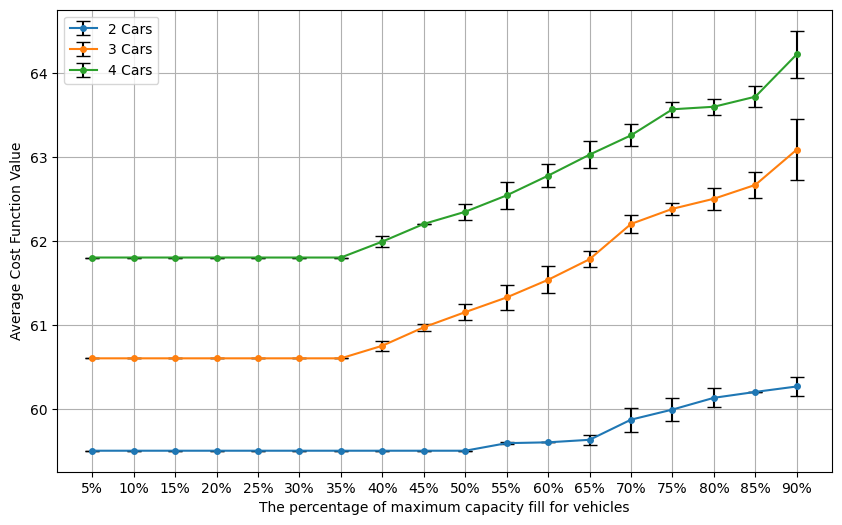

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

data_2_cars = np.array(output)
data_3_cars = np.array(output_3)
data_4_cars = np.array(output_4)

def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data, axis=1)
    std_dev = np.std(data, axis=1, ddof=1)
    n = data.shape[1]
    df = n - 1
    t_value = stats.t.ppf(1 - (1 - confidence) / 2, df)
    ci = t_value * std_dev / np.sqrt(n)
    return mean_val, ci

mean_2_cars, ci_2_cars = confidence_interval(data_2_cars)
mean_3_cars, ci_3_cars = confidence_interval(data_3_cars)
mean_4_cars, ci_4_cars = confidence_interval(data_4_cars)

load_percentages = np.arange(5, 95, 5)

plt.figure(figsize=(10, 6))

plt.errorbar([f"{num}%" for num in load_percentages], mean_2_cars, yerr=ci_2_cars, label='2 Cars', fmt='-o', markersize=4, capsize=5, ecolor='black')
plt.errorbar([f"{num}%" for num in load_percentages], mean_3_cars, yerr=ci_3_cars, label='3 Cars', fmt='-o', markersize=4, capsize=5, ecolor='black')
plt.errorbar([f"{num}%" for num in load_percentages], mean_4_cars, yerr=ci_4_cars, label='4 Cars', fmt='-o', markersize=4, capsize=5, ecolor='black')

plt.xlabel('The percentage of maximum capacity fill for vehicles')
plt.ylabel('Average Cost Function Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# print(output)
output = [[59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5], [59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5], [59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5], [59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5], [59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5], [59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5], [59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5], [59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5], [59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5], [59.499999999999986, 59.5, 59.499999999999986, 59.5, 59.5, 59.5, 59.5, 59.5, 59.499999999999986, 59.5, 59.5, 59.5, 59.499999999999986, 59.5, 59.5, 59.5, 59.5, 59.5, 59.5, 59.499999999999986], [59.5, 59.59999999999999, 59.59999999999998, 59.59999999999999, 59.59999999999999, 59.59999999999998, 59.59999999999999, 59.599999999999994, 59.59999999999998, 59.59999999999999, 59.599999999999994, 59.59999999999999, 59.499999999999986, 59.59999999999999, 59.59999999999998, 59.599999999999994, 59.59999999999998, 59.59999999999999, 59.59999999999998, 59.59999999999999], [59.599999999999994, 59.59999999999999, 59.59999999999999, 59.59999999999999, 59.59999999999998, 59.59999999999999, 59.59999999999999, 59.59999999999998, 59.59999999999999, 59.59999999999998, 59.59999999999999, 59.59999999999999, 59.59999999999999, 59.59999999999999, 59.59999999999998, 59.59999999999998, 59.59999999999999, 59.59999999999999, 59.599999999999994, 59.59999999999999], [59.59999999999998, 59.59999999999999, 59.59999999999999, 59.59999999999998, 59.59999999999998, 59.59999999999999, 59.59999999999999, 59.59999999999998, 59.59999999999998, 59.59999999999999, 59.59999999999999, 59.59999999999999, 59.59999999999998, 59.59999999999998, 60.199999999999974, 59.599999999999994, 59.59999999999999, 59.599999999999994, 59.59999999999999, 59.599999999999994], [59.59999999999999, 59.599999999999994, 60.20000000000001, 59.59999999999999, 60.19999999999999, 60.2, 60.2, 60.2, 59.59999999999998, 60.19999999999999, 59.59999999999998, 60.200000000002106, 60.19999999999999, 59.59999999999999, 59.59999999999998, 59.59999999999998, 59.59999999999999, 59.599999999999994, 60.199999999999996, 59.600000000000236], [60.199999999999996, 60.19999999999999, 60.199999999999996, 59.59999999999999, 59.59999999999998, 60.199999999999996, 60.19999999999999, 59.59999999999998, 60.199999999999996, 59.59999999999999, 60.199999999999996, 60.199999999999996, 60.199999999999996, 59.59999999999999, 60.2, 59.59999999999999, 60.199999999999996, 59.59999999999999, 60.19999999999999, 60.19999999999993], [59.59999999999999, 60.199999999998624, 60.19999999999999, 60.199999999999996, 60.2, 60.2, 60.2, 60.19999999999814, 60.2, 60.199999999999996, 60.599999999999994, 60.199999999999996, 59.59999999999999, 60.199999999999996, 60.199999999999996, 60.199999999999996, 60.199999999999946, 59.59999999999999, 60.19999999999995, 60.19999999999999], [60.19999999999999, 60.19999999999998, 60.2, 60.19999999999999, 60.199999999999996, 60.20000000000019, 60.19999999999999, 60.199999999999996, 60.199999999999996, 60.2, 60.199999999999996, 60.2, 60.19999999999999, 60.2, 60.19999999999999, 60.2, 60.199999999999996, 60.199999999999996, 60.2, 60.19999999999982], [59.599999999999994, 60.29999999999999, 60.29999999999999, 60.69999999999999, 60.199999999999996, 60.199999999999996, 60.19999999999999, 60.19999999999999, 60.699999999999996, 60.199999999999996, 60.19999999999999, 60.199999999999996, 60.19999999999999, 60.29999999999999, 60.2, 60.19999999999999, 60.29999999999999, 60.69999999999999, 60.2, 60.2]]



In [ ]:
# print(output_3)
output_3 = [[60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994], [60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994], [60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994], [60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994], [60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994], [60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994, 60.599999999999994], [60.59999999999999, 60.59999999999996, 60.59999999999998, 60.599999999999994, 60.59999999999998, 60.60000000000073, 60.59999999999998, 60.600000000003824, 60.59999999999993, 60.59999999999999, 60.59999999999996, 60.59999999999999, 60.59999999999999, 60.59999999999999, 60.59999999999998, 60.59999999999999, 60.59999999999998, 60.59999999999999, 60.599999999999994, 60.59999999999999], [60.999999999999986, 60.69999999999999, 60.69999999999999, 60.69999999999999, 60.69999999999999, 60.699999999999974, 60.999999999999986, 60.69999999999998, 60.69999999999998, 60.69999999999998, 60.69999999999999, 60.69999999999999, 60.69999999999998, 60.69999999999999, 60.99999999999998, 60.59999999999999, 60.69999999999998, 60.59999999999999, 60.699999999999996, 60.999999999999986], [60.999999999999986, 60.999999999999986, 60.999999999999986, 61.0, 60.999999999999986, 60.999999999999986, 61.0, 60.99999999999998, 60.99999999999999, 60.99999999999997, 60.999999999999986, 60.99999999999998, 60.999999999999986, 60.69999999999999, 60.999999999999986, 60.999999999999986, 61.00000000002751, 60.999999999999986, 60.999999999999986, 60.69999999999999], [60.999999999999986, 61.4, 61.3, 61.19999999999998, 61.199999999999996, 60.999999999999986, 60.999999999999986, 60.99999999999886, 61.19999999999998, 61.0, 61.199999999999996, 60.99999999999564, 61.0, 61.0, 61.4, 61.8, 61.29999999999999, 60.999999999999986, 60.999999999999986, 60.999999999999986], [60.99999999999999, 61.29999999999998, 60.999999999999986, 61.199999999999996, 60.999999999999986, 61.199999999999996, 61.199999999997786, 61.79999999999998, 61.79999999999999, 61.19999999999999, 61.79999999999999, 61.29999999999998, 61.8, 61.19999999999998, 61.0, 61.8, 61.199999999999996, 60.999999999999986, 61.70000000000311, 61.0], [61.199999999996685, 61.79999999999998, 61.800000000000004, 61.29999999999998, 61.79999999999999, 61.79999999999999, 61.79999999999998, 61.79999999999999, 61.19999999999998, 62.199999999999996, 60.999999999999986, 61.19999999999998, 61.69999999999866, 61.19999999999998, 61.29999999999999, 61.69999999999999, 61.29999999999998, 61.79999999999999, 61.79999999999998, 60.999999999999986], [61.79999999999998, 61.79999999999999, 61.8, 61.29999999999998, 61.8, 61.79999999999996, 61.29999999999998, 61.79999999999998, 61.79999999999999, 61.79999999999999, 61.800000000000004, 61.79999999999999, 61.69999999999999, 61.8, 62.199999999999505, 62.19999999999999, 61.79999999999999, 61.7, 61.79999999999998, 61.79999999999999], [62.29999999999999, 61.899999999999984, 61.69999999999999, 62.3, 62.29999999999999, 62.30000000000001, 62.29999999999999, 62.499999999999986, 62.39999999999999, 62.29999999999999, 62.5000000000122, 62.3, 61.8, 62.199999999999996, 62.19999999999999, 62.099999999999994, 62.199999999999996, 62.29999999999999, 62.29999999999999, 61.79999999999998], [62.29999999999999, 62.29999999999999, 62.30000000000001, 62.59999999999336, 62.300000000000004, 62.599999999999866, 62.59999999999999, 62.09999999999999, 62.3, 62.300000000000004, 62.30000000000001, 62.29999999999999, 62.29999999999998, 62.6, 62.59999999999999, 62.29999999999999, 62.59999999999999, 62.3, 62.29999999999998, 62.29999999999999], [62.59999999999999, 62.6, 63.3, 62.50000000000031, 62.3, 62.59999999999999, 62.300000000000296, 62.3, 63.10000000000001, 62.39999999999999, 62.29999999999998, 62.59999999999997, 62.3, 62.30000000000355, 62.29999999999998, 62.59999999999999, 62.69999999999999, 62.3, 62.29999999999999, 62.3], [63.09999999999998, 62.29999999999998, 62.599999999999994, 62.89999999999732, 63.099999999999994, 62.599999999999994, 62.59999999999999, 62.3, 62.29999999999999, 62.89999999999998, 62.3, 62.79999999999999, 62.3, 63.10000000000001, 62.59999999999999, 62.59999999999999, 62.999999999999986, 62.30000000001201, 63.3, 62.29999999999998], [63.79999999999998, 63.8, 63.099999999999994, 62.3, 63.099999999999994, 62.49999999999999, 62.59999999999999, 65.29999999999998, 62.8, 62.999999999999986, 63.3, 63.099999999999994, 62.29999999999999, 62.29999999999998, 62.79999999999998, 63.10000000000001, 62.8, 64.6, 62.8, 62.29999999999999]]

In [ ]:
# print(output_4)
output_4 = [ [61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8], [61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8], [61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8], [61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8], [61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8], [61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8, 61.8], [61.79999999999998, 61.79999999999998, 61.80000000000021, 61.79999999999999, 61.7999999999994, 61.79999999999998, 61.79999999999999, 61.79999999999999, 61.79999999999998, 61.8, 61.79999999999999, 61.8, 61.79999999999998, 61.8, 61.8, 61.8, 61.79999999999999, 61.79999999999998, 61.8, 61.79999999999999], [61.9, 61.899999999999984, 61.89999999999998, 62.19999999999999, 61.899999999999984, 62.19999999999998, 61.89999999999999, 62.199999999999996, 61.899999999999984, 61.89999999999999, 61.899999999999984, 62.19999999999999, 61.89999999999998, 62.19999999999999, 61.89999999999999, 61.89999999999998, 61.89999999999998, 61.899999999999984, 61.899999999999984, 62.19999999999998], [62.19999999999999, 62.19999999999999, 62.19999999999999, 62.19999999998617, 62.19999999999999, 62.19999999999999, 62.19999999999999, 62.19999999999999, 62.2, 62.2, 62.19999999999999, 62.19999999999999, 62.199999999999996, 62.19999999999999, 62.2, 62.2, 62.19999999999999, 62.20000000000002, 62.19999999999999, 62.19999999999998], [62.50000000000001, 62.19999999999999, 62.599999999999994, 62.19999999999999, 62.50000000000001, 62.999999999999986, 62.19999999999999, 62.500000000000014, 62.399999999999984, 62.19999999999788, 62.4, 62.19999999999999, 62.19999999999999, 62.19999999999999, 62.19999999999999, 62.4, 62.19999999999999, 62.399999999999984, 62.19999999999999, 62.19999999999999], [62.4, 62.89999999999999, 62.19999999999999, 62.499999999999986, 62.2, 62.89999999999999, 62.19999999999999, 62.19999999999999, 62.20000000000931, 62.999999999999986, 62.499999999999986, 62.49999999999999, 62.2, 62.19999999999999, 63.0, 62.500000000001776, 62.99999999999999, 62.19999999999999, 63.0, 62.99999999999999], [62.89999999999999, 62.99999999999999, 63.09999999999999, 62.999999999999986, 63.0, 62.99999999999999, 62.5, 62.99999999999999, 62.89999999999999, 62.19999999999999, 62.200000000011386, 62.999999999999986, 62.89999999999999, 62.399999999999984, 62.899999999999984, 62.49999999999999, 62.99999999999999, 62.49999999999999, 62.99999999999999, 62.499999999999986], [63.70000000000884, 62.39999999999214, 62.49999999999999, 62.99999999999999, 62.999999999999005, 62.399999999999984, 62.999999999999986, 63.00000000000002, 63.49999999999999, 63.400000000000006, 63.0, 62.999999999999986, 62.89999999999999, 63.0, 62.999999999999986, 62.89999999999999, 62.999999999999986, 63.399999999996574, 62.99999999999999, 63.39999999999999], [63.000000000008704, 62.99999999999999, 63.199999999999996, 62.499999999999986, 62.899999999999984, 63.5, 63.3, 63.199999999999996, 63.500000000002984, 63.49999999999999, 63.5, 62.999999999999986, 63.29999999999999, 63.00000000000001, 63.399999999999984, 63.5, 63.39999999999999, 63.39999999999999, 63.5, 63.49999999999999], [63.599999999999994, 63.49999999999999, 63.49999999999999, 63.699999999999996, 63.79999999999999, 63.79999999999999, 62.99999999999999, 63.5, 63.499999999999986, 63.50000000000001, 63.79999999999999, 63.5, 63.5, 63.5, 63.49999999999999, 63.5, 63.80000000000013, 63.8, 63.49999999999999, 63.499999999999986], [63.49999999999998, 63.5, 63.50000000000001, 63.50000000000073, 63.499999999999986, 64.3, 63.50000000000071, 63.49999999999999, 63.8, 63.49999999999997, 63.79999999999999, 63.500000000057156, 63.5, 63.499999999999986, 63.49999999999999, 63.5, 63.8, 63.500000000000014, 63.5, 63.699999999999996], [64.39999999999999, 63.7, 63.69999999999999, 63.50000000000001, 63.800000000000004, 63.8, 63.49999999999999, 63.8, 63.49999999999999, 63.8, 63.49999999999999, 63.80000000000019, 63.5, 63.5, 63.49999999999999, 64.29999999999998, 63.699999999999996, 63.5, 63.99999999999999, 63.50000000000001], [64.80000000000038, 64.0, 63.50000000078816, 63.49999999999999, 64.99999999999999, 63.8, 64.7, 64.3, 63.8, 64.1, 63.7, 63.49999999999999, 63.79999999999999, 63.79999999999999, 65.39999999999999, 64.09999999999998, 64.0, 65.2999999999992, 64.8, 64.49999999999999]]
